In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_datasets(output_base_dir, age_group_map, image_exists=False, verbose=True):

    # Define the dataset splits
    splits = ['train', 'validation', 'test']

    # Reverse mapping for age groups
    reverse_age_group_map = {v: k for k, v in age_group_map.items()}

    # Iterate over each split
    for split in splits:
        csv_path = os.path.join(output_base_dir, f"{split}.csv")
        if not os.path.exists(csv_path):
            if verbose:
                print(f"\nCSV file for '{split}' does not exist at {csv_path}. Skipping...")
            continue

        if verbose:
            print(f"\nAnalyzing '{split}' dataset...")

        # Load the CSV
        df = pd.read_csv(csv_path)
        initial_count = len(df)

        if verbose:
            print(f"Initial number of samples: {initial_count}")
            print("First few rows:")
            print(df.head())

        # Remove rows with missing labels
        df_clean = df.dropna(subset=['face_label', 'age_label', 'gender_label'])
        removed_na = initial_count - len(df_clean)
        if verbose:
            print(f"Dropped {removed_na} rows due to missing labels.")
            print(f"Number of samples after removing missing labels: {len(df_clean)}")

        # Normalize image paths
        df_clean['image_path'] = df_clean['image_path'].apply(lambda x: os.path.normpath(x))

        # Check if images exist
        if image_exists:
            existing_images = df_clean['image_path'].apply(lambda x: os.path.exists(x))
            valid_image_count = existing_images.sum()
            df_clean = df_clean[existing_images]
            if verbose:
                print(f"After removing non-existent images, {len(df_clean)} samples remain.")

        # Convert labels to integers
        df_clean['face_label'] = df_clean['face_label'].astype(float).astype(int)
        df_clean['gender_label'] = df_clean['gender_label'].astype(float).astype(int)

        # Map exact age to age groups only if face_label == 1
        def map_age_to_group(row):
            if row['face_label'] == 1:
                try:
                    age = int(row['age_label'])
                except:
                    return -1
                if 18 <= age <= 29:
                    return age_group_map['18-29']
                elif 30 <= age <= 39:
                    return age_group_map['30-39']
                elif 40 <= age <= 49:
                    return age_group_map['40-49']
                elif 50 <= age <= 59:
                    return age_group_map['50-59']
                elif age >= 60:
                    return age_group_map['more than 60']
                else:
                    return -1  # For ages below 18 or invalid
            else:
                return -1  # For non-face images

        df_clean['age_group'] = df_clean.apply(map_age_to_group, axis=1).astype(int)

        # Remove rows with invalid age groups only if face_label == 1
        before_age_filter = len(df_clean)
        df_valid_age = df_clean[(df_clean['face_label'] == 0) | (df_clean['age_group'] != -1)]
        removed_age = before_age_filter - len(df_valid_age)
        if verbose:
            print(f"Removed {removed_age} rows due to invalid age groups.")
            print(f"Final number of samples after cleaning: {len(df_valid_age)}")

        # Encode labels
        num_age_classes = len(age_group_map)
        age_one_hot = np.eye(num_age_classes)[df_valid_age['age_group'].values]
        df_valid_age['age_one_hot'] = age_one_hot.tolist()

        # Binary encode gender labels, handle non-face images
        df_valid_age['gender_binary'] = df_valid_age.apply(
            lambda row: float(row['gender_label']) if row['face_label'] == 1 else 0.0, axis=1
        )

        # Display summary statistics
        if verbose:
            print(f"\n--- '{split}' Dataset Summary ---")
            total_samples = len(df_valid_age)
            face_counts = df_valid_age['face_label'].value_counts().sort_index()
            print(f"Total samples: {total_samples}")
            print("Face Detection Labels:")
            print(face_counts.rename({0: 'Non-Face', 1: 'Face'}))

            # For age and gender, consider only face images
            face_df = df_valid_age[df_valid_age['face_label'] == 1]
            non_face_count = df_valid_age[df_valid_age['face_label'] == 0].shape[0]
            face_count = face_df.shape[0]

            print(f"\nFace Images: {face_count} ({face_count/total_samples*100:.2f}%)")
            print(f"Non-Face Images: {non_face_count} ({non_face_count/total_samples*100:.2f}%)")

            if face_count > 0:
                # Gender distribution
                gender_counts = face_df['gender_binary'].value_counts().sort_index()
                print("\nGender Distribution (Face Images):")
                print(gender_counts.rename({0: 'Female', 1: 'Male'}))

                # Age group distribution
                age_group_counts = face_df['age_group'].value_counts().sort_index()
                age_group_labels = [reverse_age_group_map[i] for i in age_group_map.values()]
                print("\nAge Group Distribution (Face Images):")
                print(age_group_counts.rename({i: label for i, label in enumerate(age_group_labels)}))
            else:
                print("\nNo face images to analyze gender and age distributions.")

        # Visualization
        if verbose:
            # Create subplots
            fig, axes = plt.subplots(3, 1, figsize=(10, 18))
            plt.subplots_adjust(hspace=0.4)

            # 1. Face Detection Distribution
            sns.countplot(x='face_label', data=df_valid_age, ax=axes[0], palette='Set2')
            axes[0].set_title(f"{split.capitalize()} Dataset - Face Detection")
            axes[0].set_xlabel("Face Label")
            axes[0].set_ylabel("Count")
            axes[0].set_xticklabels(['Non-Face', 'Face'])

            # 2. Gender Distribution (only Face Images)
            if face_count > 0:
                sns.countplot(x='gender_binary', data=face_df, ax=axes[1], palette='Set3')
                axes[1].set_title(f"{split.capitalize()} Dataset - Gender Distribution (Face Images)")
                axes[1].set_xlabel("Gender")
                axes[1].set_ylabel("Count")
                axes[1].set_xticklabels(['Female', 'Male'])
            else:
                axes[1].text(0.5, 0.5, 'No face images to display gender distribution.',
                             horizontalalignment='center', verticalalignment='center', fontsize=12)
                axes[1].axis('off')

            # 3. Age Group Distribution (only Face Images)
            if face_count > 0:
                sns.countplot(x='age_group', data=face_df, ax=axes[2], palette='Set1')
                axes[2].set_title(f"{split.capitalize()} Dataset - Age Group Distribution (Face Images)")
                axes[2].set_xlabel("Age Group")
                axes[2].set_ylabel("Count")
                # Set x-tick labels to age group names
                age_group_labels_present = [reverse_age_group_map[i] for i in sorted(age_group_map.values())]
                axes[2].set_xticklabels(age_group_labels_present, rotation=45)
            else:
                axes[2].text(0.5, 0.5, 'No face images to display age group distribution.',
                             horizontalalignment='center', verticalalignment='center', fontsize=12)
                axes[2].axis('off')

            plt.show()


In [2]:
age_group_map = {
    '18-29': 0,
    '30-39': 1,
    '40-49': 2,
    '50-59': 3,
    'more than 60': 4
}


In [3]:
# Define the output base directory where train.csv, validation.csv, test.csv are located
output_base_dir = '../../data/MultiTaskBalanced'  # Update this path as needed

# Call the analysis function
analyze_datasets(
    output_base_dir=output_base_dir,
    age_group_map=age_group_map,
    image_exists=False,  
    verbose=True         
)



Analyzing 'train' dataset...
Initial number of samples: 21976
First few rows:
            name                                         image_path  \
0            NaN  ../../data/MultiTaskBalanced\train\gsun_12d85d...   
1  Quinton Aaron  ../../data/MultiTaskBalanced\train\nm2466842_r...   
2   David Henrie  ../../data/MultiTaskBalanced\train\nm1273708_r...   
3            NaN  ../../data/MultiTaskBalanced\train\gsun_da476d...   
4     Eva Mendes  ../../data/MultiTaskBalanced\train\nm0578949_r...   

   face_label  age_label  gender_label  
0         0.0       -1.0          -1.0  
1         1.0       26.0           1.0  
2         1.0       18.0           1.0  
3         0.0       -1.0          -1.0  
4         1.0       31.0           0.0  
Dropped 0 rows due to missing labels.
Number of samples after removing missing labels: 21976
Removed 0 rows due to invalid age groups.
Final number of samples after cleaning: 21976


KeyboardInterrupt: 


Analyzing 'train' dataset...
Initial number of samples: 21976
First few rows:
            name                                         image_path  \
0            NaN  ../../data/MultiTaskBalanced\train\gsun_12d85d...   
1  Quinton Aaron  ../../data/MultiTaskBalanced\train\nm2466842_r...   
2   David Henrie  ../../data/MultiTaskBalanced\train\nm1273708_r...   
3            NaN  ../../data/MultiTaskBalanced\train\gsun_da476d...   
4     Eva Mendes  ../../data/MultiTaskBalanced\train\nm0578949_r...   

   face_label  age_label  gender_label  
0         0.0       -1.0          -1.0  
1         1.0       26.0           1.0  
2         1.0       18.0           1.0  
3         0.0       -1.0          -1.0  
4         1.0       31.0           0.0  
Dropped 0 rows due to missing labels.
Number of samples after removing missing labels: 21976
Removed 0 rows due to invalid age groups.
Final number of samples after cleaning: 21976

--- 'train' Dataset Summary ---
Total samples: 21976
Face Detectio

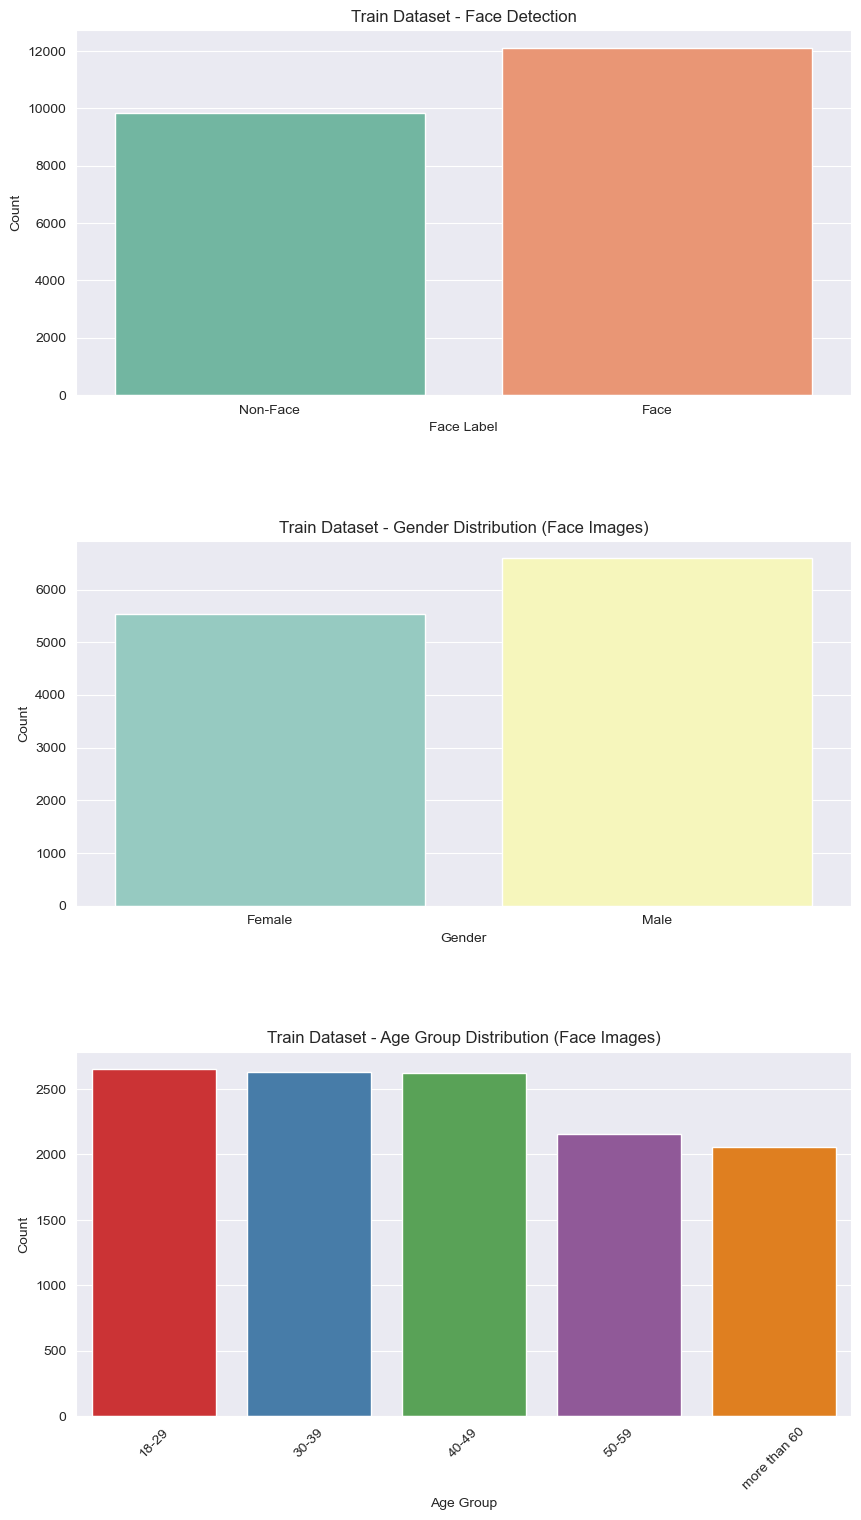


Analyzing 'validation' dataset...
Initial number of samples: 2747
First few rows:
             name                                         image_path  \
0             NaN  ../../data/MultiTaskBalanced\validation\gsun_b...   
1     Kevin Jonas  ../../data/MultiTaskBalanced\validation\nm2650...   
2  Julianne Moore  ../../data/MultiTaskBalanced\validation\nm0000...   
3    Meryl Streep  ../../data/MultiTaskBalanced\validation\nm0000...   
4             NaN  ../../data/MultiTaskBalanced\validation\gsun_e...   

   face_label  age_label  gender_label  
0         0.0       -1.0          -1.0  
1         1.0       22.0           1.0  
2         1.0       46.0           0.0  
3         1.0       60.0           0.0  
4         0.0       -1.0          -1.0  
Dropped 0 rows due to missing labels.
Number of samples after removing missing labels: 2747
Removed 0 rows due to invalid age groups.
Final number of samples after cleaning: 2747

--- 'validation' Dataset Summary ---
Total samples: 2747
F

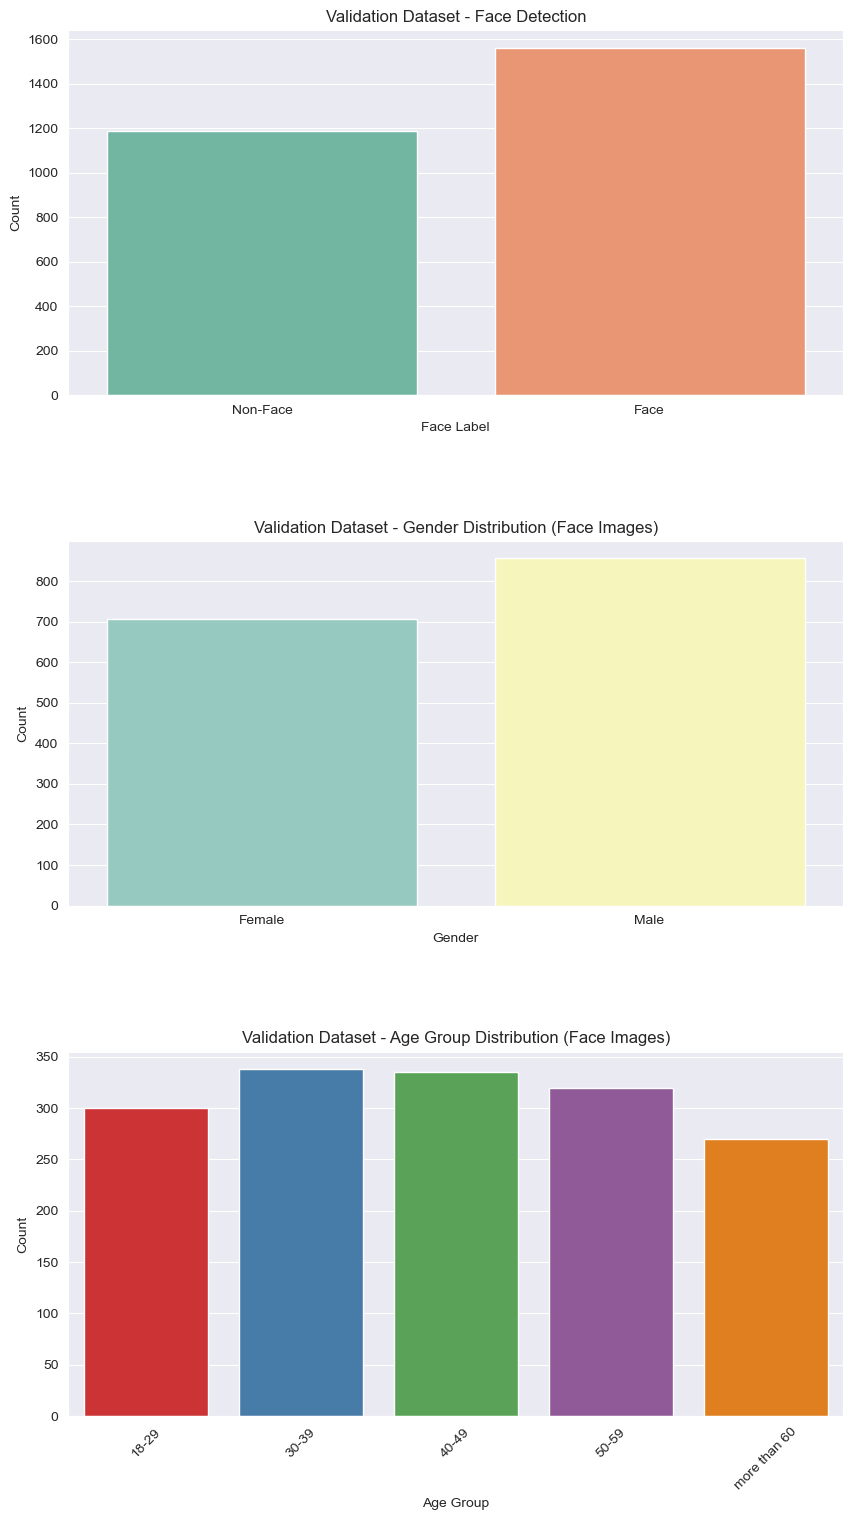


Analyzing 'test' dataset...
Initial number of samples: 2747
First few rows:
                 name                                         image_path  \
0          Cara Buono  ../../data/MultiTaskBalanced\test\nm0120648_rm...   
1  Caroline Dhavernas  ../../data/MultiTaskBalanced\test\nm0223518_rm...   
2             Unknown  ../../data/MultiTaskBalanced\test\4610775_1949...   
3                 NaN  ../../data/MultiTaskBalanced\test\gsun_86e8ee3...   
4      Paulina Gaitan  ../../data/MultiTaskBalanced\test\nm2103508_rm...   

   face_label  age_label  gender_label  
0         1.0       36.0           0.0  
1         1.0       33.0           0.0  
2         1.0       61.0           0.0  
3         0.0       -1.0          -1.0  
4         1.0       20.0           0.0  
Dropped 0 rows due to missing labels.
Number of samples after removing missing labels: 2747
Removed 0 rows due to invalid age groups.
Final number of samples after cleaning: 2747

--- 'test' Dataset Summary ---
Total sam

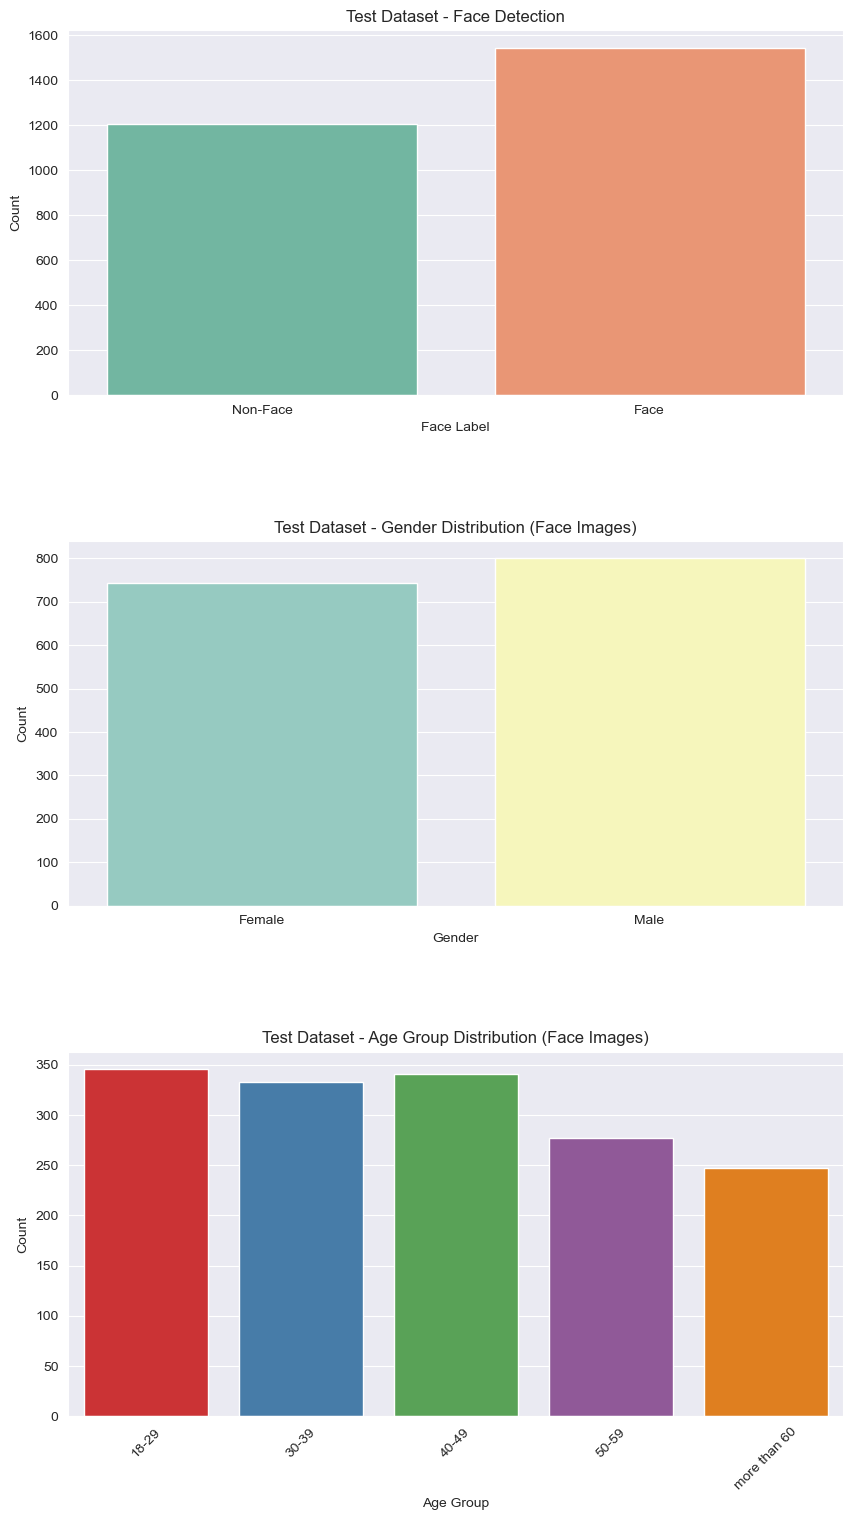

In [3]:
# Define the output base directory where train.csv, validation.csv, test.csv are located
output_base_dir = '../../data/MultiTaskBalanced'  # Update this path as needed

# Call the analysis function
analyze_datasets(
    output_base_dir=output_base_dir,
    age_group_map=age_group_map,
    image_exists=False,
    verbose=True
)
